# Example 1: s orbitals on a cubic lattice

In [1]:
# You need to set the path to the semiinf dibrectory.
path_to_semiinf = '/group2/jmlim/program/semiinf'

In [2]:
# Import modules used
import sys
import subprocess
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
sys.path.insert(1, path_to_semiinf + '/util')
from wannier_tb import TBdict

In [3]:
# make custom colormap
cdict_wr = {'red':    ((0.0,  1.0, 1.0),
                       (1.0,  1.0, 1.0)),
             'green': ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'blue':  ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0))}
cdict_br = {'red':    ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'green': ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'blue':  ((0.0,  1.0, 1.0),
                       (1.0,  1.0, 1.0))}
cmap_white_red = LinearSegmentedColormap('white_red', cdict_wr)
cmap_white_blue = LinearSegmentedColormap('white_blue', cdict_br)

First, we set the k-point path along the X-Gamma-M line.

In [4]:
# k-point path along the X-Gamma-M line
# X = (0.5, 0.0)
# Gamma = (0.0, 0.0)
# M = (0.5, 0.5)
nkdiv1 = 100
nkdiv2 = np.int(nkdiv1 * np.sqrt(2))
kxlist = np.concatenate((np.linspace(0.5, 0.0, nkdiv1, True)[:-1], np.linspace(0.0, 0.5, nkdiv2, True)))
kylist = np.concatenate((np.linspace(0.0, 0.0, nkdiv1, True)[:-1], np.linspace(0.0, 0.5, nkdiv2, True)))
kvecs = np.vstack((kxlist, kylist))
nk = kvecs.shape[1]
with open('kpath.dat', 'w') as f:
    f.write(f"{nk:8d}\n")
    for ik in range(nk):
        f.write(f"{kvecs[0,ik]:20.15f} {kvecs[1,ik]:20.15f}\n")

Now, we define the hopping parameters for the tight-binding model.

In [5]:
# Construct bulk and slab tight-binding models for s orbitals on a cubic lattice
seedname = 'cubic_s'

# Bulk tight-binding parameters
e_onsite = 1.0 # onsite energy
t_x = -1.0 # hopping along +x and -x direction
t_y = -1.0 # hopping along +y and -y direction
t_z = -1.0 # hopping along +z and -z direction

# Surface corrections
e_onsite_top = e_onsite + 2.0 # onsite energy at the topmost surface
e_onsite_bot = e_onsite - 2.0 # onsite energy at the bottommost surface
t_x_top = -0.5 # hopping along +x and -x direction at the top surface
t_y_top = -0.5 # hopping along +y and -y direction at the top surface
t_x_bot = -0.5 # hopping along +x and -x direction at the bottom surface
t_y_bot = -0.5 # hopping along +y and -y direction at the bottom surface

Then, we generate the bulk and slab tight-binding models, and write the \_hr.dat files. 
Note that the thickness of each principal layer is 1, so a 3-layer slab is sufficient.

In [6]:
# Bulk tight-binding model
# hr[ir, i, j] = <w_i, R=0|H|w_j, R=rvec[ir]>
# hk[i, j] = sum_R { hr[ir, i, j] * exp(1j * k * rvec[ir]) / ndegen[ir] }
nw = 1 # number of basis elements
nrpts = 7 # number of R vectors with nonzero hopping
hr = np.zeros((nrpts, nw, nw))
rvec = np.zeros((3, nrpts), dtype=int)
ndegen = np.zeros((nrpts,), dtype=int)

ndegen[:] = 1 # This variable is used in the Wannier90-generated tight-binding model
rvec = np.array([[ 0,  0,  0],
                 [ 1,  0,  0],
                 [-1,  0,  0],
                 [ 0,  1,  0],
                 [ 0, -1,  0],
                 [ 0,  0,  1],
                 [ 0,  0, -1]]).T
hr[0, :, :] = e_onsite
hr[1, :, :] = t_x
hr[2, :, :] = t_x
hr[3, :, :] = t_y
hr[4, :, :] = t_y
hr[5, :, :] = t_z
hr[6, :, :] = t_z

tbbulk = TBdict(nw=nw, nrpts=nrpts, hr=hr, rvec=rvec, ndegen=ndegen)

# Write to _hr.dat file
tbbulk.write_hr_dat(f'{seedname}.bulk_hr.dat')

In [7]:
# Slab tight-binding model
nw = 3
nrpts = 5
hr = np.zeros((nrpts, nw, nw))
rvec = np.zeros((3, nrpts), dtype=int)
ndegen = np.zeros((nrpts,), dtype=int)

ndegen[:] = 1
rvec = np.array([[ 0,  0,  0],
                 [ 1,  0,  0],
                 [-1,  0,  0],
                 [ 0,  1,  0],
                 [ 0, -1,  0]]).T
hr[0, :, :] = np.array([[e_onsite_top, t_z, 0.0],
                        [t_z, e_onsite, t_z],
                        [0.0, t_z, e_onsite_bot]])
hr[1, :, :] = np.diag([t_x_top, t_x, t_x_bot])
hr[2, :, :] = np.diag([t_x_top, t_x, t_x_bot])
hr[3, :, :] = np.diag([t_y_top, t_y, t_y_bot])
hr[4, :, :] = np.diag([t_y_top, t_y, t_y_bot])

tbslab = TBdict(nw=nw, nrpts=nrpts, hr=hr, rvec=rvec, ndegen=ndegen)

# Write to _hr.dat file
tbslab.write_hr_dat(f'{seedname}.slab_hr.dat')

Now, we are ready to run the semiinf.x program.

In [10]:
# Remove previous output files
bashCommand = 'rm *.out'
subprocess.call(bashCommand, stdout=subprocess.PIPE, shell=True)

# Run semiinf.x
bashCommand = f'{path_to_semiinf}/semiinf.x semiinf.in > semiinf.out'
subprocess.call(bashCommand, stdout=subprocess.PIPE, shell=True)

0

From now on, we plot the calculate DOS, together with the bulk band structures which can be calculated by direct diagonalization. This is done by the `get_bands()` function of the `TBdict` class.

In [11]:
# First, set parameters for plotting.
ne = 280 # This is printed in the semiinf.x output.
EFermi = 0.0 # reference zero energy
kmin = -0.5 
kmax = np.sqrt(2) / 2
kplot = np.linspace(kmin, kmax, nk, True)
dk = kplot[1] - kplot[0]

special_k = [kmin, 0.0, kmax] # For plotting purposes
special_k_label = ['X', '$\Gamma$', 'M'] # For plotting purposes

emin = -6.0 # Same as in semiinf.in
emax = 8.0 # Same as in semiinf.in

de = (emax - emin) / (ne - 1)

# Note the dk/2 and de/2 terms below: these are needed to align the imshow data with the plot data.
extent = [kmin-dk/2, kmax+dk/2, emin-de/2, emax+de/2]

In the `semiinf.x` code, we calculate the bulk DOS in the 2D Brillouin zone. The resulting DOS is a sum of contributions from different kz values. Hence, we plot the bulk band structure for several different kz values (note the loop over kz values).

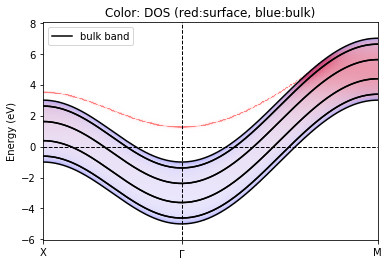

In [13]:
# Plot bulk band structure for different kz values
for ikz, kz in enumerate(np.linspace(0.0, 1.0, 10, False)):
    # Set 3D k point path
    kvecs_3d = np.vstack((kvecs, np.ones_like(kxlist) * kz))
    # Calculate band structure
    energy = tbbulk.get_bands(kvecs_3d)
    # Plot band structure
    for ib in range(tbbulk.nw):
        label = f'bulk band' if ib == 0 and ikz == 0 else None
        plt.plot(kplot, energy[ib,:], '-', c='k', label=label)

# Plot bulk and surface DOS
filenames = ['dos_bulk.out', 'dos_surf00.out']
for filename in filenames:
    # Open .out file (which is a binary file)
    with open(filename, 'r') as f:
        data = np.fromfile(f, dtype=np.float64).reshape((nk, ne))
    # Set colormap for plotting DOS (bulk: blue, surface: red)
    cmap_ = cmap_white_red
    if filename == 'dos_bulk.out':
        cmap_ = cmap_white_blue
    # Plot DOS
    plt.imshow(np.transpose(data), extent=extent, origin='lower', cmap=cmap_,
               alpha = 0.5, aspect='auto', vmin=0, vmax=0.5)
# Formatting figure
plt.xticks(special_k, special_k_label)
plt.xlim([special_k[0], special_k[-1]])
for x in special_k[1:-1]:
    plt.axvline(x=x, c='k', ls='--', lw=1)
plt.axhline(y=EFermi, c='k', ls='--', lw=1)
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Color: DOS (red:surface, blue:bulk)')
plt.show()

We can also compare the calculated DOS with the band structure of a thick slab. First, we make a function that generates a TBdict object for given number of layers.

In [14]:
# Slab tight-binding model
def get_tbthickslab(nlayer):
    if nlayer < 3:
        raise ValueError("Slab must be thicker than 2 layer")
    nw = nlayer
    nrpts = 5
    hr = np.zeros((nrpts, nw, nw))
    rvec = np.zeros((3, nrpts), dtype=int)
    ndegen = np.zeros((nrpts,), dtype=int)

    ndegen[:] = 1
    rvec = np.array([[ 0,  0,  0],
                     [ 1,  0,  0],
                     [-1,  0,  0],
                     [ 0,  1,  0],
                     [ 0, -1,  0]]).T
    hr[0, :, :] = np.diag([e_onsite_top] + [e_onsite] * (nw - 2) + [e_onsite_bot])
    for i in range(nw-1):
        hr[0, i, i+1] += t_z
        hr[0, i+1, i] += t_z
    hr[1, :, :] = np.diag([t_x_top] + [t_x] * (nw - 2) + [t_x_bot])
    hr[2, :, :] = np.diag([t_x_top] + [t_x] * (nw - 2) + [t_x_bot])
    hr[3, :, :] = np.diag([t_y_top] + [t_y] * (nw - 2) + [t_y_bot])
    hr[4, :, :] = np.diag([t_y_top] + [t_y] * (nw - 2) + [t_y_bot])

    return TBdict(nw=nw, nrpts=nrpts, hr=hr, rvec=rvec, ndegen=ndegen)

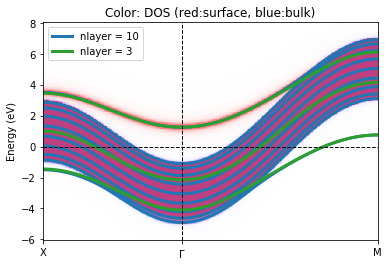

In [16]:
# Plot bulk band structure
for ilayer, nlayer in enumerate([10, 3]):
    # Set 3D k point path. Since this is a slab, kz can be ignored (i.e. set to zero)
    kvecs_3d = np.vstack((kvecs, np.zeros_like(kxlist)))
    # Generate tight-binding model object using the function defined previously.
    tbthickslab = get_tbthickslab(nlayer)
    # Calculate band structure
    energy = tbthickslab.get_bands(kvecs_3d)
    # Plot band structure
    c = f'C{ilayer*2}'
    for ib in range(tbthickslab.nw):
        label = f'nlayer = {nlayer}' if ib == 0 else None
        plt.plot(kplot, energy[ib,:], '-', c=c, label=label, lw=3)

# Plot bulk and surface DOS
filenames = ['dos_bulk.out', 'dos_surf00.out']
for filename in filenames:
    # Open .out file (which is a binary file)
    with open(filename, 'r') as f:
        data = np.fromfile(f, dtype=np.float64).reshape((nk, ne))
    # Set colormap for plotting DOS (bulk: blue, surface: red)
    cmap_ = cmap_white_red
    if filename == 'dos_bulk.out':
        cmap_ = cmap_white_blue
    # Plot DOS
    plt.imshow(np.transpose(data), extent=extent, origin='lower', cmap=cmap_,
               alpha = 0.5, aspect='auto', vmin=0, vmax=0.01)
# Formatting figure
plt.xticks(special_k, special_k_label)
plt.xlim([special_k[0], special_k[-1]])
for x in special_k[1:-1]:
    plt.axvline(x=x, c='k', ls='--', lw=1)
plt.axhline(y=EFermi, c='k', ls='--', lw=1)
plt.ylabel('Energy (eV)')
plt.title('Color: DOS (red:surface, blue:bulk)')
plt.legend()
plt.show()

The surface states (surface DOS in the bulk gapped region) are well-represented even with a 3-layer slab.
However, other contributions (surface DOS that overlap with the bulk DOS) requires a thicker slab to be faithfully represented.

The surface state energy around 0eV around the M point is the surface state of the bottom surface.
You can verify this by calculating the semiinfinite surface DOS of the bottom surface. To do this, you should modify the semiinf.in file.